In [1]:
import numpy as np
import seaborn as sns
import torch
import random
import pathlib
import os
import glob
import scipy
import cv2
import math
from matplotlib import pyplot as plt
import pandas as pd
from skimage.transform import resize
import tqdm
import torch.nn.functional as F

from PraNet.utils.dataloader import test_dataset
from PraNet.lib.PraNet_Res2Net import PraNet
from skimage.filters import gaussian
from skimage.morphology import label as connected_components

In [2]:
# !nvidia-smi

## Data Preparation

In [3]:
## libraries for data loader 
import glob
import sys
import torch
sys.path.insert(0,'/media/htic/_srv_Data/Ayantika_codebase/datasets/')
import slice_data_h5 as sdl_h5
from monai.transforms import (
    Orientationd, AddChanneld, Compose, ToTensord, Spacingd,Resized,ScaleIntensityD,ResizeWithPadOrCropd
    # ScaleIntensityD, ScaleIntensityRangeD, AdjustContrastD, RandAffined, ToNumpyd,RepeatChannelD
)
transforms1 = Compose(
    [
     AddChanneld(('image','label')),
     Orientationd(('image','label'),'RAS'),
#      Spacingd(('image','label'),(1,1,1)),        
     Resized(keys = ('image'),spatial_size = (128, 128,-1),mode = 'trilinear' ,align_corners = True),
     Resized(keys = ('label'),spatial_size = (128, 128,-1),mode = 'nearest' ),
     ScaleIntensityD(('image',)),
     ToTensord(('image','label')),
    ]
)
brats_datapath_1 = '/media/htic/_srv_Data/brain/BRATS_HGG_T2/**_t2.nii.gz'
trainlist_1 = [{'image':x} for x in glob.glob(brats_datapath_1)]
datalist = trainlist_1

masklist = [{'label':x.split('_t2.nii.gz')[0]+'_seg.nii'} for x in glob.glob(brats_datapath_1)]

### The loader is such that it would create h5 files if they are not created when the loader is called and executed
h5cachedir_ = '/media/htic/_srv_Data/brain/h5_data/BRATS_T2'                                                                  
h5cacheds = sdl_h5.H5CachedDataset(datalist,masklist,transforms1,h5cachedir=h5cachedir_)
#                                    nslices_per_image = 155,\
#                                    start_slice = 0,end_slice = 1)
#                                    start_slice = 60,end_slice = 90)
torch.multiprocessing.set_sharing_strategy('file_system')
brats_loader = torch.utils.data.DataLoader(h5cacheds,batch_size = 1,\
                                           shuffle = True ,num_workers= 1)# ,pin_memory = True)


In [4]:
import argparse
from omegaconf import OmegaConf
parser = argparse.ArgumentParser(description="Glow trainer")
parser.add_argument("--batch", default=5, type=int, help="batch size")
parser.add_argument("--epoch", default=10, type=int, help="maximum iterations")
parser.add_argument(
    "--n_flow", default=32, type=int, help="number of flows in each block"
)
parser.add_argument("--n_block", default=4, type=int, help="number of blocks")
parser.add_argument(
    "--no_lu",
    action="store_true",
    help="use plain convolution instead of LU decomposed version",
)
parser.add_argument(
    "--affine", action="store_true", help="use affine coupling instead of additive"
)
parser.add_argument("--n_bits", default=5, type=int, help="number of bits")
parser.add_argument("--lr", default=1e-4, type=float, help="learning rate")
parser.add_argument("--img_size", default=128, type=int, help="image size")
parser.add_argument("--temp", default=0.7, type=float, help="temperature of sampling")
parser.add_argument("--n_sample", default=20, type=int, help="number of samples")
args = parser.parse_args('')
args_dict = vars(args)

conf_ = OmegaConf.create(args_dict)
OmegaConf.save(config=conf_, f='./glow_args.yaml')
OmegaConf.to_yaml(conf_)
args= OmegaConf.load('./glow_args.yaml') 

import sys
sys.path.insert(0,'/media/htic/_srv_Data/Ayantika_codebase/')
from models.glow_model_Copy1 import Glow
model_single = Glow(
        1, args.n_flow, args.n_block, affine=args.affine, conv_lu=not args.no_lu
    )
    
model = torch.nn.DataParallel(model_single)
# model = model_single


weights_path = '/media/htic/_srv_Data/Research/MICCAI_Disentanglement/best_weights/model_000009.pth'
model.load_state_dict(torch.load(weights_path))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/media/htic/_srv_Data/Ayantika_codebase/models/glow_model_Copy1.py:103: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  w_s = torch.from_numpy(w_s)


In [5]:
z_sample_norm = lambda z_sample: z_sample*(3/torch.abs(z_sample.max()))
# z_sample_norm = lambda z_sample: z_sample/torch.linalg.norm(z_sample)

def norm_to_gauss_sample(latent_space):
    z_sample=latent_space
    z_sample_= []
    z_sample_.append(z_sample_norm(z_sample[0]))
    z_sample_.append(z_sample_norm(z_sample[1]))
    z_sample_.append(z_sample_norm(z_sample[2]))
    z_sample_.append(z_sample_norm(z_sample[3]))
    
    return z_sample_


def return_reconstruction(latent_space):
    z_sample = norm_to_gauss_sample(latent_space)
    z_sample_img = model_single.reverse(z_sample,reconstruct=False).cpu().data
    return z_sample_img


image_norm = lambda image_: (image_ - image_.min())/(image_.max() - image_.min())

In [25]:
torch.sum(image_['label'][130:131,0,:,:]) == 0

tensor(False)

In [53]:
dict_save = {}
set_names = "img_org, img_,recon_ , res , label"
set_names_list = set_names.split(',')

n_bins = 2.0 ** args.n_bits
with torch.no_grad():
    for i,image_ in enumerate(tqdm.tqdm(brats_loader)):  
        if torch.sum(image_['label'][:,:,:,:]) != 0:
            image = image_['image'][:,:,:,:].to(device)

            image = image * 255

            if args.n_bits < 8:
                image = torch.floor(image / 2 ** (8 - args.n_bits))

            image = image / n_bins - 0.5   

            if True:
                with torch.no_grad():
                     out,log_p, logdet, latent_space= model(
                        image + torch.rand_like(image) / n_bins
                    )
    #                     image + torch.rand_like(image) / n_bins


            else:
                with torch.no_grad():
                    out,log_p, logdet, latent_space = model(image + torch.rand_like(image) / n_bins)
                    
            z_sample_img = return_reconstruction(latent_space)
            
            img_org = image_['image'][0,0,:,:]
            img_ = image[0,0,:,:].cpu() 
            recon_ = z_sample_img[0,0,:,:].cpu()
            res = (img_- recon_) 
            label = image_['label'][0,0,:,:]
            imgs_set = img_org, img_,recon_ , res , label
            imgs_set_norm = [image_norm(i) for i in imgs_set]
            
            for (val,names) in zip(imgs_set_norm,set_names_list):
                if names not in dict_save.keys():
                    dict_save.update({names:val.unsqueeze(dim=0)})
                else:
                    dict_save[names] = torch.cat((dict_save[names],val.unsqueeze(dim=0)),dim=0)



#             break


  0%|                                                                                         | 0/27720 [00:00<?, ?it/s]/home/htic/GE_APW/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 62%|█████████████████████████████████████████████▏                           | 17159/27720 [1:48:33<2:07:35,  1.38it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [58]:
# create torch files accumulating all of thes
# i

In [68]:
# dict_save
# dict_keys(['img_org', ' img_', 'recon_ ', ' res ', ' label'])

In [102]:

patch_gt_inst__ = dict_save[' label'][0:1000,:,:]
patch_pred_inst__ = dict_save[' res '][0:1000,:,:] * (dict_save[' img_'][0:1000,:,:]>0)
masks = patch_gt_inst__
regions = patch_pred_inst__

In [112]:
# torch.sum(masks[0])
# plt.imshow(patch_pred_inst__[180,:,:])

## Conformal

In [260]:
def loss_False_Pos(T, risk_mass, masks): # lambda in [-1,0]
    # Get the missed pixels 
    num_polyps = masks.max(dim=1)[0].max(dim=1)[0]

    False_pos = (T.to(int) - (masks>0).to(int))
    F.relu(False_pos, inplace=True) 
    # False_pos = False_pos * masks
    results_perpolyp = torch.zeros((num_polyps.sum().int().item(), \
                                    masks.shape[1], masks.shape[2]))
    #     print("num_polyps",num_polyps.sum().int().item())
    masks_perpolyp = torch.zeros_like(results_perpolyp)
    # results_perpolyp.shape
    k = 0
    for n in range(num_polyps.max().int().item()):
        filter_bool = (num_polyps >= n + 1) # 1, 2, 3 polyps 
        temp_False_pos = False_pos[filter_bool]
        temp_masks = masks[filter_bool]
        results_perpolyp[k:k+temp_False_pos.shape[0]] = (temp_False_pos == n + 1)
        masks_perpolyp[k:k+temp_False_pos.shape[0]] = (temp_masks == n+1)
        k += temp_False_pos.shape[0] 
        
    results_perpolyp = results_perpolyp.to(float).sum(dim=1).sum(dim=1)/((128*128) - masks_perpolyp.sum(dim=1).sum(dim=1))
    return results_perpolyp

In [261]:
def get_example_loss_and_size_tables_False_Pos(regions, masks, lambdas_example_table, num_calib):
    lam_len = len(lambdas_example_table)
    lam_low = min(lambdas_example_table)
    lam_high = max(lambdas_example_table)
    fname_loss = f'.cache_trained/{lam_low}_{lam_high}_{lam_len}_example_loss_table.npy'
    fname_sizes = f'.cache_trained/{lam_low}_{lam_high}_{lam_len}_example_size_table.npy'
    try:
        loss_table = np.load(fname_loss)
        sizes_table = np.load(fname_sizes)
    except:
        print("computing loss and size table")
        loss_table = np.zeros((regions.shape[0], lam_len))
        sizes_table = np.zeros((regions.shape[0], lam_len))
#         print(loss_table.shape,sizes_table.shape)
        for j in tqdm.tqdm(range(lam_len)):
            est_regions = (regions >= -lambdas_example_table[j])
#             print("loss_False_Neg",loss_False_Neg(est_regions, regions, masks).shape)
#             print("loss_table[:,j] ",loss_table[:,j].shape)
            loss_table[:,j] = loss_False_Pos(est_regions, regions, masks) 
            sizes_table[:,j] = est_regions.sum(dim=1).sum(dim=1)/((128*128) - masks.sum(dim=1).sum(dim=1))

        np.save(fname_loss, loss_table)
        np.save(fname_sizes, sizes_table)


        return loss_table, sizes_table
# example_loss_table, example_sizes_table = get_example_loss_and_size_tables(regions, masks, \
#                                                                                    lambdas_example_table, \
#                                                                                    num_calib)

In [262]:
def loss_False_Neg(T, risk_mass, masks): # lambda in [-1,0]
    # Get the missed pixels 
    num_polyps = masks.max(dim=1)[0].max(dim=1)[0]
    
    missed = ((masks>0).to(int) - T.to(int)) # as lambda grows, the sets grow.
    F.relu(missed, inplace=True) 
    # Split the different polyps into different rows.
    missed = missed * masks
    results_perpolyp = torch.zeros((num_polyps.sum().int().item(), \
                                    masks.shape[1], masks.shape[2]))
#     print("num_polyps",num_polyps.sum().int().item())
    masks_perpolyp = torch.zeros_like(results_perpolyp)
    k = 0
    for n in range(num_polyps.max().int().item()):
        filter_bool = (num_polyps >= n + 1) # 1, 2, 3 polyps 
        temp_missed = missed[filter_bool]
        temp_masks = masks[filter_bool]
        results_perpolyp[k:k+temp_missed.shape[0]] = (temp_missed == n + 1)
        masks_perpolyp[k:k+temp_missed.shape[0]] = (temp_masks == n+1)
        k += temp_missed.shape[0] 
    results_perpolyp = results_perpolyp.to(float).sum(dim=1).sum(dim=1)/masks_perpolyp.sum(dim=1).sum(dim=1)    
    return results_perpolyp

In [263]:
def get_example_loss_and_size_tables(regions, masks, lambdas_example_table, num_calib):
    lam_len = len(lambdas_example_table)
    lam_low = min(lambdas_example_table)
    lam_high = max(lambdas_example_table)
    fname_loss = f'.cache_trained/{lam_low}_{lam_high}_{lam_len}_example_loss_table.npy'
    fname_sizes = f'.cache_trained/{lam_low}_{lam_high}_{lam_len}_example_size_table.npy'
    try:
        loss_table = np.load(fname_loss)
        sizes_table = np.load(fname_sizes)
    except:
        print("computing loss and size table")
        loss_table = np.zeros((regions.shape[0], lam_len))
        sizes_table = np.zeros((regions.shape[0], lam_len))
#         print(loss_table.shape,sizes_table.shape)
        for j in tqdm.tqdm(range(lam_len)):
            est_regions = (regions >= -lambdas_example_table[j])
#             print("loss_False_Neg",loss_False_Neg(est_regions, regions, masks).shape)
#             print("loss_table[:,j] ",loss_table[:,j].shape)
            loss_table[:,j] = loss_False_Neg(est_regions, regions, masks) 
            sizes_table[:,j] = est_regions.sum(dim=1).sum(dim=1)/masks.sum(dim=1).sum(dim=1)

        np.save(fname_loss, loss_table)
        np.save(fname_sizes, sizes_table)


        return loss_table, sizes_table
# example_loss_table, example_sizes_table = get_example_loss_and_size_tables(regions, masks, \
#                                                                                    lambdas_example_table, \
#                                                                                    num_calib)

In [264]:
def trial_precomputed(example_loss_table, example_size_table, alpha, num_calib, num_lam, lambdas_example_table):
    total=example_loss_table.shape[0]
    perm = torch.randperm(example_loss_table.shape[0])
    example_loss_table = example_loss_table[perm]
    example_size_table = example_size_table[perm]
    calib_losses, val_losses = (example_loss_table[0:num_calib], example_loss_table[num_calib:])
    calib_sizes, val_sizes = (example_size_table[0:num_calib], example_size_table[num_calib:])

    lhat = get_lhat(calib_losses[:,::-1], lambdas_example_table[::-1], alpha)

    losses = val_losses[:,np.argmax(lambdas_example_table == lhat)]
    #print(lhat,losses)
    size = np.random.choice(val_sizes[:,np.argmax(lambdas_example_table == lhat)])

    return lhat, losses.mean(), size

In [265]:
def get_lhat(calib_loss_table, lambdas, alpha, B=1):
    n = calib_loss_table.shape[0]
    rhat = calib_loss_table.mean(axis=0)
#     print()

    lhat_idx = max(np.argmax(((n/(n+1)) * rhat + B/(n+1)) >= alpha) - 1, 0) # Can't be -1.
    #print(lhat_idx, lambdas[lhat_idx])
    return lambdas[lhat_idx]



In [266]:
def plot_histograms(df, alpha, output_dir):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
    axs[0].hist(df['risk'].to_numpy(), alpha=0.7, density=True)

    normalized_size = df['sizes'].to_numpy()
    axs[1].hist(normalized_size, bins=60, alpha=0.7, density=True)

    axs[0].set_xlabel('risk')
    axs[0].locator_params(axis='x', nbins=10)
    axs[0].axvline(x=alpha,c='#999999',linestyle='--',alpha=0.7)
    axs[0].set_ylabel('density')
    axs[1].set_xlabel('set size as a fraction of polyp size')
    axs[1].locator_params(axis='x', nbins=10)
    axs[1].set_yscale('log')
    #axs[1].legend()
    sns.despine(top=True, right=True, ax=axs[0])
    sns.despine(top=True, right=True, ax=axs[1])
    plt.tight_layout()
    plt.savefig( output_dir + (f'{alpha}_polyp_histograms').replace('.','_') + '.pdf'  )
    print(f"The mean and standard deviation of the risk over {len(df)} trials are {df['risk'].mean()} and {df['risk'].std()} respectively.")

In [267]:
def fix_randomness(seed=0):
    np.random.seed(seed=seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)

In [268]:
import shutil
# shutil.rmtree(cache_path)
# patch_gt_inst__.shape
shutil.rmtree('./.cache_trained/')

In [269]:
with torch.no_grad():
        sns.set(palette='pastel', font='serif')
        sns.set_style('white')
        fix_randomness()

        cache_path = './.cache_trained/'
        output_dir = 'outputs/histograms/'
        pathlib.Path(cache_path).mkdir(parents=True, exist_ok=True)
        pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

        num_trials = len(patch_gt_inst__)
        num_calib = 500
        num_lam = 500
        alpha = 0.03
        lambdas_example_table = np.linspace(-1,0,500)
        masks = patch_gt_inst__
        regions = patch_pred_inst__
        # num_components = get_data(cache_path)
        masks[masks > 1] = 1
#         df = experiment(patch_gt_inst__, patch_gt_inst__, alpha, num_trials, \
#                         num_calib, num_lam, output_dir, lambdas_example_table)



        fname = cache_path +'/'+ f'{alpha}_{num_calib}_{num_lam}_dataframe'.replace('.','_') + '.pkl'
    #     os.makedirs(fname, exist_ok=True)

        df = pd.DataFrame(columns=['$\\hat{\\lambda}$','risk','sizes','alpha'])
    #     try:
    #         print('Dataframe loaded')
    #         df = pd.read_pickle(fname)
    #     except:
        example_loss_table_FP, example_sizes_table_FP = get_example_loss_and_size_tables_False_Pos(regions, masks, \
                                                                                   lambdas_example_table, \
                                                                                   num_calib)

#         local_df_list = []
#         for i in tqdm.tqdm(range(num_trials)):
#             lhat, risk, sizes = \
#             trial_precomputed(example_loss_table, example_sizes_table, alpha, num_calib, num_lam, lambdas_example_table)
# #             print("lhat",lhat)
#             dict_local = {"$\\hat{\\lambda}$": lhat, "risk": risk, "sizes": sizes, "alpha": alpha}
#             df_local = pd.DataFrame(dict_local, index=[i])
#             local_df_list = local_df_list + [df_local]
#         df = pd.concat(local_df_list, axis=0, ignore_index=True)
#         df.to_pickle(fname)
#         plot_histograms(df, alpha, output_dir)


computing loss and size table


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [02:17<00:00,  3.63it/s]


computing loss and size table


100%|████████████████████████████████████████████████████████████████████████████████| 654/654 [00:00<00:00, 736.67it/s]


The mean and standard deviation of the risk over 654 trials are 0.04778028364407875 and 0.007966967581959165 respectively.


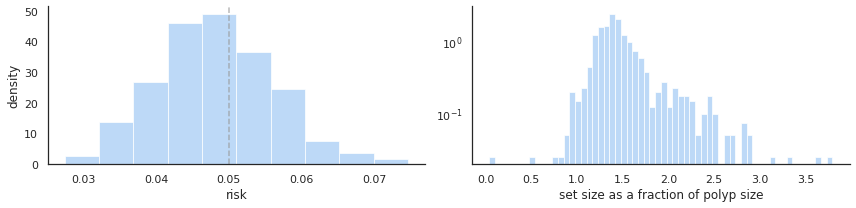

In [17]:
with torch.no_grad():
        sns.set(palette='pastel', font='serif')
        sns.set_style('white')
        fix_randomness()

        cache_path = './.cache_trained/'
        output_dir = 'outputs/histograms/'
        pathlib.Path(cache_path).mkdir(parents=True, exist_ok=True)
        pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

        num_trials = len(patch_gt_inst__)
        num_calib = 500
        num_lam = 500
        alpha = 0.05
        lambdas_example_table = np.linspace(-1,0,500)
        masks = patch_gt_inst__
        regions = patch_pred_inst__
        # num_components = get_data(cache_path)
        masks[masks > 1] = 1
#         df = experiment(patch_gt_inst__, patch_gt_inst__, alpha, num_trials, \
#                         num_calib, num_lam, output_dir, lambdas_example_table)



        fname = cache_path +'/'+ f'{alpha}_{num_calib}_{num_lam}_dataframe'.replace('.','_') + '.pkl'
    #     os.makedirs(fname, exist_ok=True)

        df = pd.DataFrame(columns=['$\\hat{\\lambda}$','risk','sizes','alpha'])
    #     try:
    #         print('Dataframe loaded')
    #         df = pd.read_pickle(fname)
    #     except:
        example_loss_table, example_sizes_table = get_example_loss_and_size_tables(regions, masks, \
                                                                                   lambdas_example_table, \
                                                                                   num_calib)

        local_df_list = []
        for i in tqdm.tqdm(range(num_trials)):
            lhat, risk, sizes = \
            trial_precomputed(example_loss_table, example_sizes_table, alpha, num_calib, num_lam, lambdas_example_table)
#             print("lhat",lhat)
            dict_local = {"$\\hat{\\lambda}$": lhat, "risk": risk, "sizes": sizes, "alpha": alpha}
            df_local = pd.DataFrame(dict_local, index=[i])
            local_df_list = local_df_list + [df_local]
        df = pd.concat(local_df_list, axis=0, ignore_index=True)
        df.to_pickle(fname)
        plot_histograms(df, alpha, output_dir)


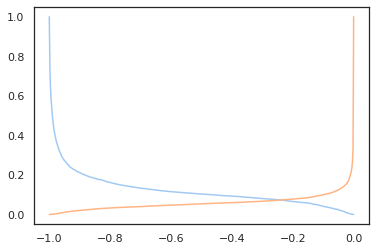

In [43]:
plt.plot(lambdas_example_table,example_loss_table[0])
plt.plot(lambdas_example_table,example_loss_table_FP[0])
# example_loss_table.shape
# lambdas_example_table.shape

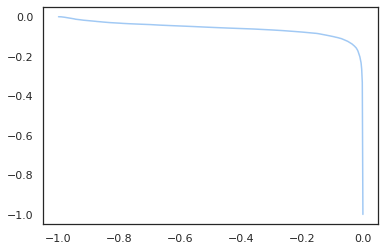

In [44]:
plt.plot(lambdas_example_table,-example_loss_table_FP[0])

In [270]:
def get_lhat_FP(calib_loss_table, lambdas, alpha, B=1):
    n = calib_loss_table.shape[0]
    rhat = calib_loss_table.mean(axis=0)
#     print()

    lhat_idx = max(np.argmax(((n/(n+1)) * rhat + B/(n+1)) <= alpha) - 1, 0) # Can't be -1.
    #print(lhat_idx, lambdas[lhat_idx])
    return lambdas[lhat_idx]

In [271]:
def trial_precomputed(example_loss_table, example_size_table, alpha, num_calib, num_lam, lambdas_example_table):
    total=example_loss_table.shape[0]
    perm = torch.randperm(example_loss_table.shape[0])
    example_loss_table = example_loss_table[perm]
    example_size_table = example_size_table[perm]
    calib_losses, val_losses = (example_loss_table[0:num_calib], example_loss_table[num_calib:])
    calib_sizes, val_sizes = (example_size_table[0:num_calib], example_size_table[num_calib:])

    lhat = get_lhat_FP(calib_losses[:,::-1], lambdas_example_table[::-1], alpha,0)

    losses = val_losses[:,np.argmax(lambdas_example_table == lhat)]
    #print(lhat,losses)
    size = np.random.choice(val_sizes[:,np.argmax(lambdas_example_table == lhat)])

    return lhat, losses.mean(), size

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 484.04it/s]


The mean and standard deviation of the risk over 1000 trials are 0.010296887174885519 and 0.0009001944310611012 respectively.


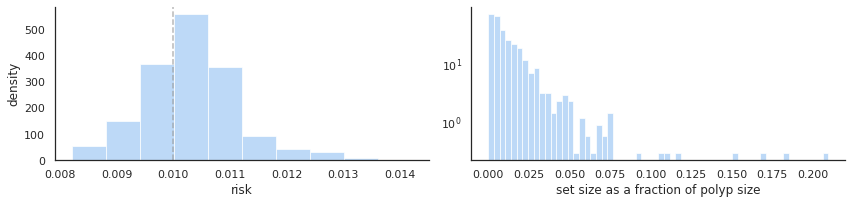

In [272]:
local_df_list = []
for i in tqdm.tqdm(range(num_trials)):
    lhat, risk, sizes = \
    trial_precomputed(example_loss_table_FP, example_sizes_table_FP, alpha, num_calib, num_lam, lambdas_example_table)
#             print("lhat",lhat)
    dict_local = {"$\\hat{\\lambda}$": lhat, "risk": risk, "sizes": sizes, "alpha": alpha}
    df_local = pd.DataFrame(dict_local, index=[i])
    local_df_list = local_df_list + [df_local]
df = pd.concat(local_df_list, axis=0, ignore_index=True)
df.to_pickle(fname)
plot_histograms(df, alpha, output_dir)

In [273]:
lhat

-0.7855711422845691

(array([ 14.,   0.,   0.,   0.,   0.,   0.,   0., 101.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 230.,   0.,   0.,   0.,   0.,   0.,   0.,
        335.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 220.,   0.,   0.,
          0.,   0.,   0.,   0.,  75.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,  19.,   0.,   0.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.]),
 array([-0.79358717, -0.79331997, -0.79305277, -0.79278557, -0.79251837,
        -0.79225117, -0.79198397, -0.79171677, -0.79144957, -0.79118236,
        -0.79091516, -0.79064796, -0.79038076, -0.79011356, -0.78984636,
        -0.78957916, -0.78931196, -0.78904476, -0.78877756, -0.78851035,
        -0.78824315, -0.78797595, -0.78770875, -0.78744155, -0.78717435,
        -0.78690715, -0.78663995, -0.78637275, -0.78610554, -0.78583834,
        -0.78557114, -0.78530394, -0.78503674, -0.78476954, -0.78450234,
        -0.78423514, -0.78396794, -0.78370073, -0.78343353, -0.78316633,
      

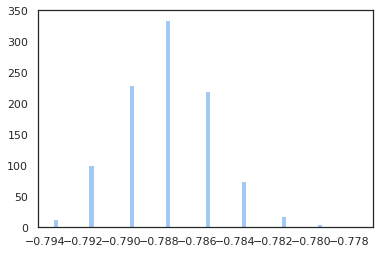

In [274]:
plt.hist(df['$\hat{\lambda}$'],bins=60)
# lhat


In [275]:
patch_gt_accum = patch_gt_inst__
patch_pred_accum = patch_pred_inst__

In [276]:
# np.unique(patch_gt_inst__[in_dex])

torch.Size([128, 128])

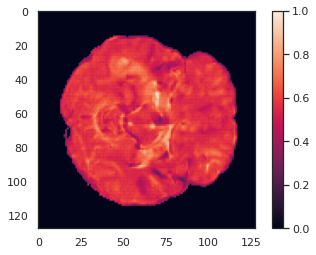

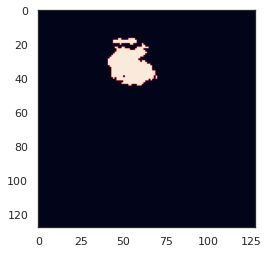

In [290]:
in_dex = 679
plt.imshow(patch_pred_accum[in_dex])
plt.colorbar()
plt.figure()
plt.imshow(patch_gt_inst__[in_dex])
patch_gt_inst__[in_dex].shape

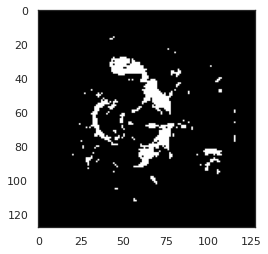

In [299]:
# plt.imshow(patch_pred_accum[in_dex]>(-df['$\hat{\lambda}$'].mean()),cmap='gray')
plt.imshow(patch_pred_accum[in_dex]>0.65,cmap='gray')

In [309]:
# defining the kernel i.e. Structuring element
import cv2
kernel = np.ones((5, 5), np.uint8)
mm_ = np.array(patch_pred_accum[in_dex]>0.65).astype('int64')
# defining the opening function 
# over the image and structuring element
# np.unique(mm_),mm_.dtype
opening = cv2.morphologyEx(mm_, cv2.MORPH_OPEN, kernel)

error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/morph.simd.hpp:756: error: (-213:The function/feature is not implemented) Unsupported data type (=4) in function 'getMorphologyRowFilter'


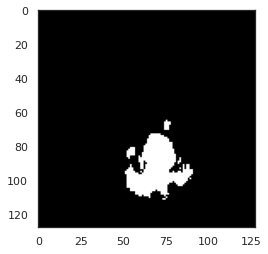

In [284]:
plt.imshow(patch_gt_accum[in_dex],cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


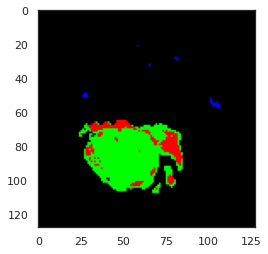

In [198]:
final_ = np.array(torch.ones(patch_gt_accum.shape[-2],patch_gt_accum.shape[-1],3))
pred = np.array(patch_pred_accum[in_dex]>(-df['$\hat{\lambda}$'].mean()))
gt_ = np.array(patch_gt_accum[in_dex]>0)
final_[:,:,0] = (pred & gt_) * 255
final_[:,:,1] = ((pred & gt_) ^ (gt_)) * 255
final_[:,:,2] = ((pred & gt_) ^ (pred)) * 255
plt.imshow(final_)
# plt.imshow()

In [199]:
metrics = lambda pred,gt_: ((pred & gt_).sum(),((pred & gt_) ^ (gt_)).sum(),\
                               ((pred & gt_) ^ (pred)).sum(), (~pred & ~gt_).sum())

In [249]:
pred = np.array(patch_pred_accum>(-df['$\hat{\lambda}$'].mean()))
gt_ = np.array(patch_gt_accum>0)
TP_FN_FP_TN=metrics(pred,gt_)
FNR = TP_FN_FP_TN[1]*100/(TP_FN_FP_TN[1]+TP_FN_FP_TN[0])
FPR = TP_FN_FP_TN[2]*100/(TP_FN_FP_TN[2]+TP_FN_FP_TN[3])
dice = 2*TP_FN_FP_TN[0]/(2*TP_FN_FP_TN[0]+TP_FN_FP_TN[1]+TP_FN_FP_TN[2])
FPR,FNR,dice

(1.7130118570291961, 89.41413760289421, 0.14324046066246274)

In [294]:
pred = np.array(patch_pred_accum>0.65)
gt_ = np.array(patch_gt_accum>0)
TP_FN_FP_TN=metrics(pred,gt_)
FNR = TP_FN_FP_TN[1]*100/(TP_FN_FP_TN[1]+TP_FN_FP_TN[0])
FPR = TP_FN_FP_TN[2]*100/(TP_FN_FP_TN[2]+TP_FN_FP_TN[3])
dice = 2*TP_FN_FP_TN[0]/(2*TP_FN_FP_TN[0]+TP_FN_FP_TN[1]+TP_FN_FP_TN[2])
FPR,FNR,dice

(10.499125525103118, 59.07938287052322, 0.22176714716428222)

In [216]:
lam_ = np.linspace(0,1,100)
dice_list = []
FNR_list = []
FPR_list = []
for i in tqdm.tqdm(range(0,len(lam_))):
    pred = np.array(patch_pred_accum>lam_[i])
    gt_ = np.array(patch_gt_accum>0)
    TP_FN_FP_TN=metrics(pred,gt_)
    FNR_list.append(TP_FN_FP_TN[1]/(TP_FN_FP_TN[1]+TP_FN_FP_TN[0]))
    
    FPR_list.append(TP_FN_FP_TN[2]/(TP_FN_FP_TN[2]+TP_FN_FP_TN[3]))
    dice = 2*TP_FN_FP_TN[0]/(2*TP_FN_FP_TN[0]+TP_FN_FP_TN[1]+TP_FN_FP_TN[2])
    dice_list.append(dice)
    
    


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  9.04it/s]


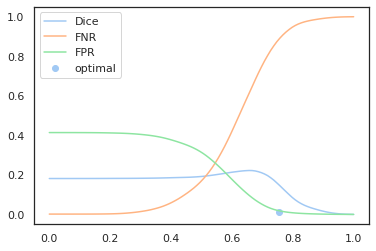

In [259]:
plt.plot(lam_,dice_list,label='Dice')
plt.plot(lam_,FNR_list,label='FNR')
plt.plot(lam_,FPR_list,label='FPR')
plt.scatter(-lhat,alpha,label='optimal')
# plt.yticks()
plt.legend()

In [325]:
in_dex=198

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


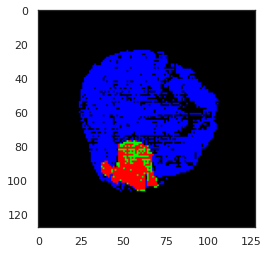

In [326]:
final_ = np.array(torch.ones(patch_gt_accum.shape[-2],patch_gt_accum.shape[-1],3))
pred = np.array(patch_pred_accum[in_dex]>0.65)
gt_ = np.array(patch_gt_accum[in_dex]>0)
final_[:,:,0] = (pred & gt_) * 255
final_[:,:,1] = ((pred & gt_) ^ (gt_)) * 255
final_[:,:,2] = ((pred & gt_) ^ (pred)) * 255
plt.imshow(final_)

In [327]:
TP_FN_FP_TN=metrics(pred,gt_)
FNR = TP_FN_FP_TN[1]*100/(TP_FN_FP_TN[1]+TP_FN_FP_TN[0])
FPR = TP_FN_FP_TN[2]*100/(TP_FN_FP_TN[2]+TP_FN_FP_TN[3])
dice = 2*TP_FN_FP_TN[0]/(2*TP_FN_FP_TN[0]+TP_FN_FP_TN[1]+TP_FN_FP_TN[2])
FPR,FNR,dice

(22.554675118858952, 24.794745484400657, 0.19805405405405405)